# TRABAJO PRACTICO N°2

## Ejercicio 1

Basándose en los trabajos
- Performance Modelling of Imaging Service or Earth Observation Satellites with Two-dimensional Markov
Chain
- Queuing theory application in imaging service analysis for small Earth observation satellites
Se pide implementar las soluciones propuestas por los autores utilizando Cadenas de Markov, y Teoría de Colas,
considerando:

__a)__ Utilizar el generador de números al azar implementado en el Trabajo Práctico 1 para generar los números al
azar utilizados en el ejercicio (comparar los resultados con los obtenidos si se utilizan los números al azar
provistos por el lenguaje elegido).

__b)__ Probar distintos escenarios

__c) Opcional__: Comparar los resultados obtenidos, con los resultados que se obtendrían con un Generador
Congruencial Lineal de módulo $2^{32}$, multiplicador 1013904223, incremento de 1664525 y semilla igual a la
parte entera del promedio de los números de padrón de los integrantes del grupo

### <span style="color:red">Resolucion Ejercicios 1 y 2</span>

In [7]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

__GCL generado en el Trabajo Practico 1__

In [8]:
# PAPER 1
class xorshift:
    max64bit = (2**64) 
 
    def __init__(self,seed):
        self.seed = seed % self.max64bit

    def rand(self):
        # a=13 b=7 c=17
        # Python no tiene limite de valores para int asi que aplico modulo de 64 bits
        # para simular el comportamiento de C y tener periodo de (2^64 - 1) ----> Confirmado: Hay que imitar la implementacion del paper
        self.seed = (self.seed ^ (self.seed << 13)) % self.max64bit
        self.seed = (self.seed ^ (self.seed >> 7)) % self.max64bit
        self.seed = (self.seed ^ (self.seed << 17)) % self.max64bit

        return self.seed
    # Dividimos por el módulo para obtener valores en [0,1]
    def uniform_rand(self):
        return self.rand()/self.max64bit

    def uniform_rand_minutes_in_day(self):
        return int(self.uniform_rand() * MINUTES_IN_DAY)

In [9]:
rng = xorshift(int(time.time()))
df_rng = [rng.rand() for i in range(1000)]
df_rng_uniform = [rng.uniform_rand() for i in range(1000)]

**Generador opcional**

Generador Congruencial Lineal (GCL) de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo.

El método Lineal Congruente funciona de la siguiente manera:

$${X}_{n+1}=(aX_n + c)~mod~m, ~~~n>=0$$
$$m, ~the~ modulus, ~0<m$$
$$a, ~the~ multiplier, ~0<=a<m$$
$$c, ~the~ increment, ~0<=c<m$$
$$X_0, ~the~ starting~ value, ~0<=X_0<m$$

A partir de esto generaremos el generador GCL con los datos provistos

In [10]:
MINUTES_IN_DAY = 1440

In [5]:
class RandOp:
    
    # m:modulus
    # a:multiplier
    # c:increment
    m = 2**32
    a = 1013904223
    c = 1664525
    xn = int((97576+93956+104093+96444+98408)/5)
    
    def rand(self):
        self.xn = (self.a*self.xn + self.c)%self.m
        return self.xn
    
    # Dividimos por el módulo para obtener valores en [0,1]
    def uniform_rand(self):
        return self.rand()/self.m
    
    def uniform_rand_minutes_in_day(self):
        return int(self.uniform_rand() * MINUTES_IN_DAY)

In [11]:
randOp= RandOp()
randoms= [randOp.rand() for i in range(1000)]
randoms_uniform = [randOp.uniform_rand() for i in range(1000)]
random_seconds = [randOp.uniform_rand_minutes_in_day() for i in range(100)]

### Modelo 1: Sistema de Servicio de Captura de Imagen Pura

<div>
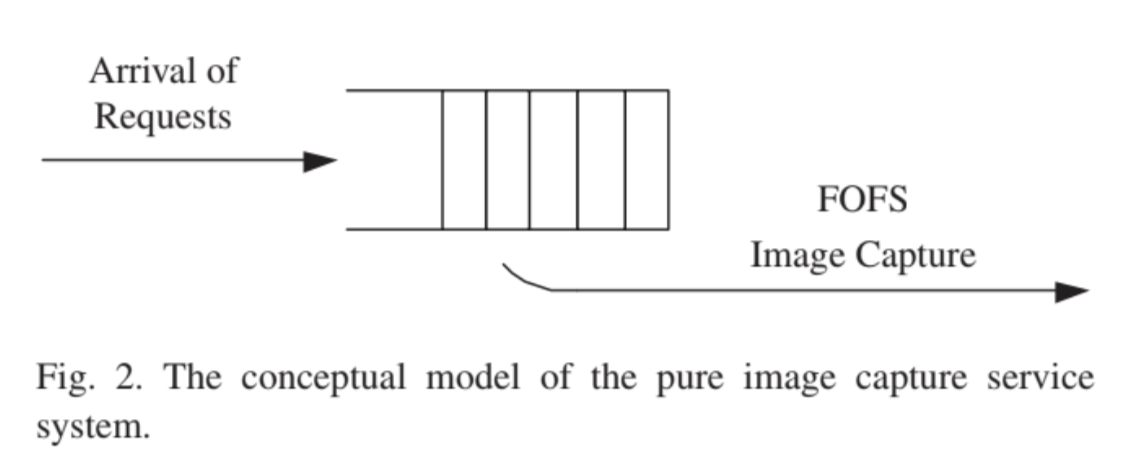
</div>

#### Hipótesis: 
- No hay límite de solicitudes
- La tasa de llegadas es conocida y la denotamos como $\lambda$
- La tasa de tiempo de servicio es conocida y la denotamos como $\mu$
- Se considera que el tiempo de captura de la imagen es despreciable respecto de el tiempo de servicio total de la request

El sistema es modelado como $M/M/1$, sabiendo que el tiempo de llegadas sigue una distribución exponencial de parámetro $\lambda$ y el tiempo de servicio sigue una distribución exponencial de parámetro $\mu$.

Planteamos entonces el siguiente sistema:

Siguiendo la disciplina FOFS (First-Opportunity-First-Served), sabemos que a todas las solicitudes que llegan al satélite que aún no han sido capturadas, se las considera y trata de la misma manera por el planificador del sistema, con un software de predicción de órbitas y calculando las ventanas de tiempo de oportunidad de visita para cada solicitud. Así, el programa siempre elige la solicitud que tenga la primera oportunidad de visitar para poder procesarla primero.

Además, sabemos que la ubicación de destino de las requests se distribuyen uniformemente en todo el mundo. Por lo tanto, se podría decir que sus coordenadas son aleatorias siguiendo una distribución uniforme.
Dicho esto podemos concluir que, si las coordenadas de cada request son aleatorias, la prioridad que le dará el satélite a cada una de ellas respecto de su posición también lo será.

Por lo tanto, simularemos con el generador XorShift propuesto en [Marsaglia, G. "Xorshift RNGs"](https://drive.google.com/file/d/1OeDTXLWPXuuIuhVsTS5ttx_yAkbfumJk/view), para cada una de las requests, una cantidad de minutos de 0 a 1440 por día; simulando el tiempo necesario para llegar a esa ubicación en el trayecto de la órbita del satélite.

Una vez desencolada una request para ser procesada, se contempla el tiempo en el que entró en la cola, el tiempo actual y el tiempo necesario para llegar hasta esa ubicación, y se calcula el tiempo de servicio total para dicha request; dando así por terminado su procesamiento. Luego, se procede con la siguiente request encolada.

Es importante destacar que, por cada unidad de tiempo, se siguen encolando requests con una distribución de Poisson según el $\lambda$ dado.

In [12]:
import heapq
import copy
import logging
import sys
from random import randint

def print_status(i):
    sys.stdout.write(f"\r {i}")
    sys.stdout.flush()
    
def python_random():
    return randint(0,MINUTES_IN_DAY)

In [8]:
class Satellite_model1:
    def __init__(self, arrival_rate, random_num_function):
        self.arrival_rate = arrival_rate
        self.requests_queue = []
        self.clock = 0
        self.state_logs = [0]
        self.req_logs = []
        self.rand_op = random_num_function
        self.num_req = 0
        
    def push_request(self,req_dist):
        """saves req as (distance_to_target, moment_of_start)"""
        req = (req_dist, self.clock)
        heapq.heappush(self.requests_queue,req)
        
        self.num_req += 1
    
    def pop_request(self):
        req = heapq.heappop(self.requests_queue)
        travel_time = req[0]
        time_stamp_start = req[1]
                
        serv_time = self.clock - time_stamp_start + travel_time
        req_log = (time_stamp_start, self.clock + travel_time, serv_time)
        self.req_logs.append(req_log)
        
        self.num_req -= 1
        self.state_logs.append(self.num_req)

        return travel_time
        
    def number_of_req(self):
        return self.num_req
    
    def get_poisson_reqs(self):
        number_of_arrivals = np.random.poisson(self.arrival_rate)
        new_reqs = []
        self.state_logs.append(number_of_arrivals + self.num_req)
        for i in range(number_of_arrivals):
            new_reqs.append(self.rand_op())
        
        return new_reqs
    
    def print_reqs(self):
        heap = copy.deepcopy(self.requests_queue)
        str_heap = []
        while len(heap) > 0:
            str_heap.append(str(heapq.heappop(heap)))
        
        print_status(f"Requests Queue: {' -> '.join(str_heap[:10])} ...")
    
    def print_state_logs(self):
        print('\n \t\t ************ Estados: ************ \n')
        state_logs = map(str, self.state_logs)
        print(" -> ".join(state_logs))
    
    def print_req_logs(self):
        print("\n \t\t ************ Requests Logs: ************ \n")
        print("N° Request \t Moment of Arrival \t Moment of Exit \t Duration(min)")
        
        for i in range(len(self.req_logs)):
            req = self.req_logs[i]
            print(f" {i} \t\t\t {req[0]} \t\t\t {req[1]} \t\t\t {req[2]} ")

    def print_service_rate(self,days):
        print(f"\n\nService Rate Per Minute: {len(self.req_logs)/(days * MINUTES_IN_DAY)}")
        print(f"\nService Rate Per Day: {len(self.req_logs)/days}")
    
    def get_new_reqs(self):
        new_reqs = self.get_poisson_reqs()
        for req in new_reqs:
            self.push_request(req)
            self.print_reqs()
    
    def get_state_logs(self):
        return self.state_logs

    def get_service_times(self):
        reqs = []
        for i in range(len(self.req_logs)):
            req = self.req_logs[i]
            reqs.append(req[2])
        return reqs
    
    def orbit_days(self, days):
        
        i = 0
        while i < days * MINUTES_IN_DAY:
            
            self.clock = i
            serv_time = 1

            while self.number_of_req() == 0:
                self.get_new_reqs()
                i += 1
                
            serv_time = self.pop_request()
            
            while serv_time > 0:
                self.get_new_reqs()
                if serv_time > 1:
                    i += 1
                serv_time -= 1
            
            i+= 1
        
        self.print_service_rate(days)
        self.print_state_logs()
        self.print_req_logs()
        

### Modelo 1 Xorshift
Corremos el programa con nuestro generador $xorshift$ del trabajo práctico 1.

In [9]:
sat = Satellite_model1(2,rng.uniform_rand_minutes_in_day)
sat.orbit_days(1)

 Requests Queue: (16, 0) -> (18, 0) -> (18, 0) -> (19, 0) -> (20, 0) -> (20, 1176) -> (21, 0) -> (21, 0) -> (21, 0) -> (21, 0) ................

Service Rate Per Minute: 0.025694444444444443

Service Rate Per Day: 37.0

 		 ************ Estados: ************ 

0 -> 3 -> 2 -> 3 -> 4 -> 5 -> 6 -> 8 -> 12 -> 15 -> 19 -> 20 -> 23 -> 24 -> 25 -> 27 -> 30 -> 34 -> 35 -> 38 -> 39 -> 41 -> 42 -> 42 -> 43 -> 43 -> 47 -> 50 -> 53 -> 55 -> 55 -> 59 -> 60 -> 61 -> 63 -> 64 -> 67 -> 67 -> 68 -> 71 -> 75 -> 76 -> 81 -> 83 -> 86 -> 86 -> 88 -> 89 -> 93 -> 96 -> 99 -> 100 -> 103 -> 105 -> 105 -> 106 -> 107 -> 108 -> 109 -> 109 -> 111 -> 111 -> 115 -> 117 -> 117 -> 120 -> 122 -> 126 -> 127 -> 127 -> 128 -> 131 -> 132 -> 134 -> 137 -> 139 -> 140 -> 141 -> 141 -> 146 -> 150 -> 152 -> 153 -> 155 -> 156 -> 158 -> 160 -> 163 -> 165 -> 168 -> 169 -> 172 -> 174 -> 176 -> 178 -> 181 -> 185 -> 185 -> 189 -> 191 -> 192 -> 194 -> 196 -> 203 -> 207 -> 210 -> 212 -> 214 -> 217 -> 219 -> 221 -> 222 -> 225 -> 226 -> 

[]

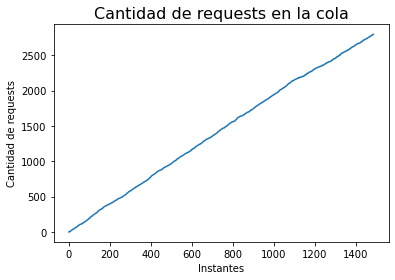

In [10]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat.get_state_logs())
plt.title("Cantidad de requests en la cola", size=16)
plt.ylabel("Cantidad de requests")
plt.xlabel("Instantes")
plt.plot()


### Modelo 1 Random.randint
Corremos el programa con el generador de número random de Python

In [11]:
sat2 = Satellite_model1(2,python_random)
sat2.orbit_days(1)

 Requests Queue: (8, 1431) -> (13, 1394) -> (26, 1423) -> (31, 0) -> (32, 0) -> (33, 0) -> (33, 0) -> (33, 0) -> (33, 569) -> (33, 1015) ....

Service Rate Per Minute: 0.04236111111111111

Service Rate Per Day: 61.0

 		 ************ Estados: ************ 

0 -> 3 -> 2 -> 5 -> 5 -> 8 -> 10 -> 13 -> 14 -> 17 -> 20 -> 20 -> 23 -> 26 -> 31 -> 32 -> 36 -> 39 -> 41 -> 43 -> 45 -> 47 -> 49 -> 52 -> 52 -> 53 -> 54 -> 54 -> 55 -> 57 -> 59 -> 60 -> 61 -> 61 -> 65 -> 71 -> 71 -> 72 -> 77 -> 78 -> 78 -> 81 -> 82 -> 82 -> 83 -> 83 -> 85 -> 87 -> 88 -> 91 -> 92 -> 96 -> 97 -> 98 -> 102 -> 106 -> 109 -> 110 -> 111 -> 113 -> 113 -> 113 -> 116 -> 118 -> 121 -> 125 -> 126 -> 126 -> 127 -> 128 -> 129 -> 130 -> 132 -> 134 -> 137 -> 141 -> 144 -> 148 -> 151 -> 151 -> 153 -> 154 -> 158 -> 160 -> 163 -> 164 -> 164 -> 168 -> 172 -> 175 -> 179 -> 182 -> 185 -> 189 -> 190 -> 193 -> 195 -> 195 -> 200 -> 202 -> 205 -> 208 -> 211 -> 212 -> 218 -> 219 -> 222 -> 222 -> 224 -> 227 -> 228 -> 231 -> 233 -> 233 -> 236 

[]

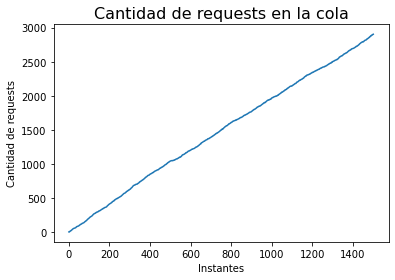

In [12]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat2.get_state_logs())
plt.title("Cantidad de requests en la cola", size=16)
plt.ylabel("Cantidad de requests")
plt.xlabel("Instantes")
plt.plot()


### Modelo 1 Generador de Números Opcional
Corremos el programa con el generador de números opcional

In [13]:
sat3 = Satellite_model1(2,randOp.uniform_rand_minutes_in_day)
sat3.orbit_days(1)

 Requests Queue: (13, 0) -> (14, 0) -> (14, 0) -> (14, 0) -> (15, 0) -> (15, 0) -> (16, 0) -> (18, 0) -> (18, 0) -> (18, 0) ................

Service Rate Per Minute: 0.020833333333333332

Service Rate Per Day: 30.0

 		 ************ Estados: ************ 

0 -> 1 -> 0 -> 4 -> 6 -> 6 -> 8 -> 11 -> 14 -> 20 -> 23 -> 24 -> 25 -> 28 -> 31 -> 32 -> 38 -> 40 -> 44 -> 44 -> 48 -> 51 -> 55 -> 57 -> 60 -> 63 -> 64 -> 66 -> 68 -> 70 -> 73 -> 75 -> 78 -> 79 -> 80 -> 81 -> 83 -> 85 -> 85 -> 86 -> 90 -> 92 -> 94 -> 96 -> 98 -> 101 -> 104 -> 106 -> 109 -> 113 -> 117 -> 119 -> 120 -> 123 -> 126 -> 127 -> 129 -> 132 -> 134 -> 134 -> 136 -> 138 -> 142 -> 143 -> 146 -> 148 -> 154 -> 155 -> 158 -> 159 -> 163 -> 167 -> 168 -> 169 -> 169 -> 170 -> 170 -> 171 -> 174 -> 175 -> 178 -> 179 -> 181 -> 182 -> 183 -> 183 -> 183 -> 185 -> 187 -> 187 -> 188 -> 189 -> 192 -> 193 -> 195 -> 197 -> 197 -> 200 -> 200 -> 202 -> 202 -> 203 -> 203 -> 205 -> 208 -> 209 -> 210 -> 210 -> 213 -> 215 -> 216 -> 216 -> 219 -> 221

[]

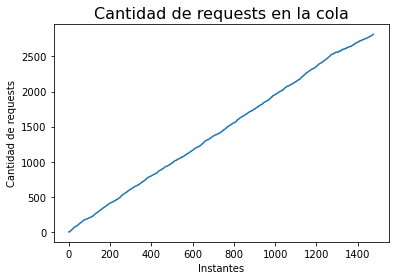

In [14]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat3.get_state_logs())
plt.title("Cantidad de requests en la cola", size=16)
plt.ylabel("Cantidad de requests")
plt.xlabel("Instantes")
plt.plot()

### Modelo 3: Sistema de servicio de descarga de imágenes puro

<div>
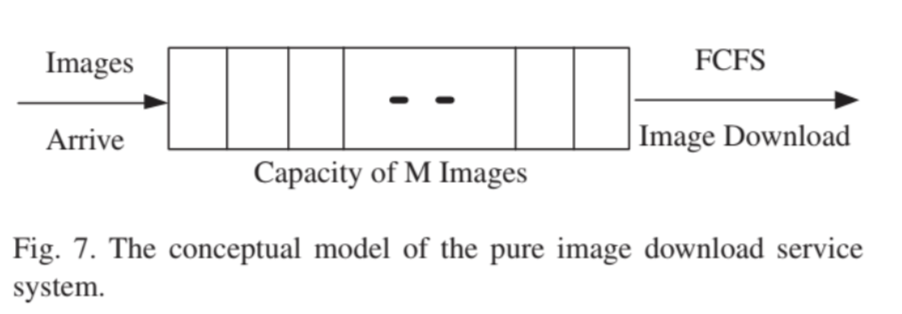
</div>

#### Hipótesis: 
Los supuestos relacionados son los siguientes:

- El patrón de llegada de las imágenes se distribuye Poisson, con la tasa de llegada $\lambda$.
- La capacidad de almacenamiento a bordo es $M$, es decir, se almacenan a lo sumo $M$ imágenes en la memoria esperando la operación de descarga. Para cada operación de descarga, hay una única imagen descargada.

In [15]:
class Satellite_model2:
    def __init__(self, arrival_rate, download_rate, max_queue):
        self.arrival_rate = arrival_rate
        self.download_rate = download_rate
        self.requests_queue = []
        self.clock = 0
        self.state_logs = [0]
        self.req_logs = []
        self.num_req = 0
        self.max_queue = max_queue
        
    def push_request(self,req_dist):
        """saves req as (distance_to_target, moment_of_start)"""
        req = (req_dist, self.clock)
        self.requests_queue.append(req)
        
        self.num_req += 1
    
    def pop_request(self):
        req = self.requests_queue.pop(0)
        travel_time = req[0]
        time_stamp_start = req[1]
                
        serv_time = self.clock - time_stamp_start + travel_time
        req_log = (time_stamp_start, self.clock + travel_time, serv_time)
        self.req_logs.append(req_log)
        
        self.num_req -= 1
        self.state_logs.append(self.num_req)

        return travel_time
        
    def number_of_req(self):
        return self.num_req
    
    def get_poisson_reqs(self):
        number_of_arrivals = np.random.poisson(self.arrival_rate)
        new_reqs = []
        self.state_logs.append(number_of_arrivals + self.num_req)
        
        for i in range(number_of_arrivals):
            new_reqs.append(int(np.random.exponential(self.download_rate)))
        
        return new_reqs
    
    def print_reqs(self):
        heap = copy.deepcopy(self.requests_queue)
        str_heap = []
        while len(heap) > 0:
            str_heap.append(str(heapq.heappop(heap)))
        
        print_status(f"Requests Queue: {' -> '.join(str_heap[:10])} ...")
    
    def print_state_logs(self):
        print('\n \t\t ************ Estados: ************ \n')
        state_logs = map(str, self.state_logs)
        print(" -> ".join(state_logs))
    
    def print_req_logs(self):
        print("\n \t\t ************ Requests Logs: ************ \n")
        print("N° Request \t Moment of Arrival \t Moment of Exit \t Duration(min)")
        
        for i in range(len(self.req_logs)):
            req = self.req_logs[i]
            print(f" {i} \t\t\t {req[0]} \t\t\t {req[1]} \t\t\t {req[2]} ")

    def print_service_rate(self,days):
        print(f"\n\nService Rate Per Minute: {len(self.req_logs)/(days * MINUTES_IN_DAY)}")
        print(f"\nService Rate Per Day: {len(self.req_logs)/days}")
    
    def get_new_reqs(self):
        new_reqs = self.get_poisson_reqs()
        for req in new_reqs:
            self.push_request(req)
            self.print_reqs()
    
    def get_state_logs(self):
        return self.state_logs
    
    def get_service_times(self):
        reqs = []
        for i in range(len(self.req_logs)):
            req = self.req_logs[i]
            reqs.append(req[2])
        return reqs
    
    def orbit_days(self, days):
        
        i = 0
        while i < days * MINUTES_IN_DAY:
            
            self.clock = i
            serv_time = 1

            while self.number_of_req() == 0:
                self.get_new_reqs()
                i += 1
                
            serv_time = self.pop_request()
            
            while serv_time > 0 and (self.num_req + 2 * self.arrival_rate) < self.max_queue:
                self.get_new_reqs()
                if serv_time > 1:
                    i += 1
                serv_time -= 1
            
            i+= 1
        
        self.print_service_rate(days)
        self.print_state_logs()
        self.print_req_logs()

In [16]:
sat = Satellite_model2(2, 2, 200)
sat.orbit_days(1)

 Requests Queue: (0, 1189) -> (0, 1189) -> (0, 1191) -> (0, 1193) -> (0, 1193) -> (0, 1193) -> (0, 1193) -> (0, 1200) -> (0, 1200) -> (0, 1205) ...

Service Rate Per Minute: 0.7395833333333334

Service Rate Per Day: 1065.0

 		 ************ Estados: ************ 

0 -> 2 -> 1 -> 2 -> 3 -> 6 -> 5 -> 6 -> 5 -> 7 -> 6 -> 6 -> 12 -> 11 -> 12 -> 11 -> 10 -> 12 -> 11 -> 15 -> 19 -> 19 -> 18 -> 23 -> 25 -> 28 -> 30 -> 29 -> 29 -> 28 -> 31 -> 30 -> 29 -> 31 -> 30 -> 32 -> 35 -> 35 -> 36 -> 35 -> 35 -> 37 -> 40 -> 39 -> 40 -> 40 -> 42 -> 46 -> 48 -> 49 -> 49 -> 49 -> 51 -> 53 -> 52 -> 54 -> 55 -> 57 -> 58 -> 57 -> 58 -> 59 -> 60 -> 61 -> 64 -> 69 -> 68 -> 72 -> 72 -> 71 -> 70 -> 71 -> 70 -> 73 -> 74 -> 74 -> 73 -> 73 -> 72 -> 74 -> 77 -> 76 -> 80 -> 79 -> 80 -> 81 -> 82 -> 85 -> 84 -> 83 -> 82 -> 84 -> 85 -> 88 -> 87 -> 86 -> 89 -> 90 -> 94 -> 94 -> 97 -> 96 -> 98 -> 99 -> 98 -> 97 -> 100 -> 101 -> 102 -> 104 -> 106 -> 105 -> 105 -> 108 -> 107 -> 108 -> 107 -> 110 -> 113 -> 115 -> 117 -> 118 ->

[]

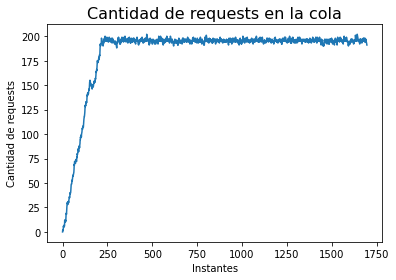

In [17]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat.get_state_logs())
plt.title("Cantidad de requests en la cola", size=16)
plt.ylabel("Cantidad de requests")
plt.xlabel("Instantes")
plt.plot()

[]

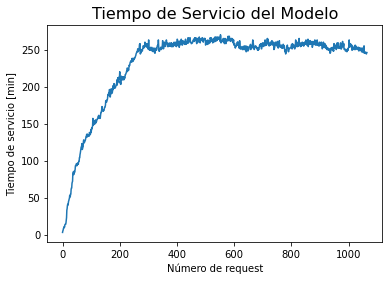

In [18]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat.get_service_times())
plt.title("Tiempo de Servicio del Modelo", size=16)
plt.ylabel("Tiempo de servicio [min]")
plt.xlabel("Número de request")
plt.plot()

Como era de esperar, la cantidad de requests en la entrada crece rápidamente con una evolución similar a una lineal, y al llegar al límite se "plancha", oscilando levemente cerca de ese valor.

### Modelo 2 : Tiempo de Servicio con distribución Exponencial $\mu_d$

Si corremos nuestro Modelo 3 con la tasa de requests procesadas del modelo 1 como la tasa de llegadas a la cola de descarga, estaríamos simulando entonces un Modelo 2.


<div>
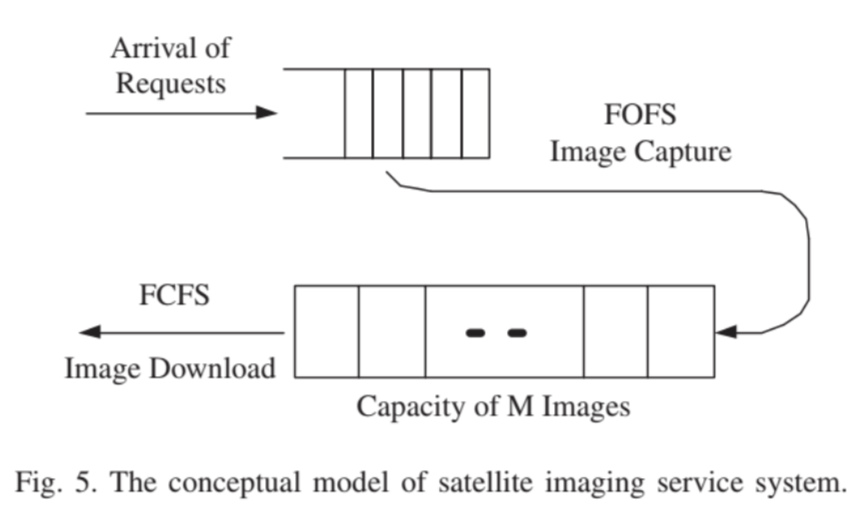
</div>

Además de los supuestos en la sección 1, los otros supuestos relacionados son los siguientes:

- El límite de longitud de la cola de captura de imágenes es $N$, es decir, hay como máximo $N$ solicitudes que se esperan la operación de captura de imágenes. En este trabajo, sólo consideramos el caso cuando $N$ es lo suficientemente grande como tan similar con el caso infinito, al igual que en el paper (Queuing theory application in imaging service analysis for small Earth observation satellites)[https://drive.google.com/file/d/1JXfrjPBOoCBTBbskOMVy82_k2UXzg-OF/view].
- La capacidad de almacenamiento a bordo es $M$, es decir, se almacenan hasta $M$ imágenes en la memoria esperando la operación de descarga.
- Para cada operación de descarga hay una y solo una imagen descargada.
- El tiempo de servicio de descarga de una imagen se supone exponencialmente distribuido con la media $1/\mu_d$, que es conocido.

In [19]:
sat = Satellite_model2(0.05347, 2, 200)
sat.orbit_days(1)

 Requests Queue: (1, 1422) ..., 91) ...

Service Rate Per Minute: 0.05416666666666667

Service Rate Per Day: 78.0

 		 ************ Estados: ************ 

0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 1 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 2 -> 1 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 ->

[]

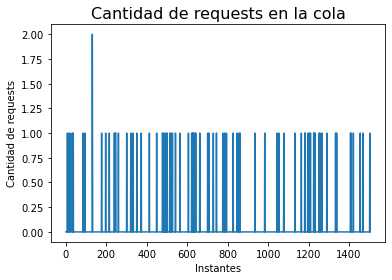

In [20]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat.get_state_logs())
plt.title("Cantidad de requests en la cola", size=16)
plt.ylabel("Cantidad de requests")
plt.xlabel("Instantes")
plt.plot()

[]

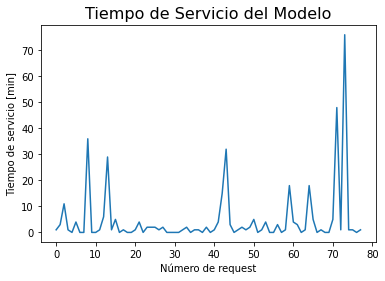

In [21]:
fig = plt.figure()
ax = plt.axes()

ax.plot(sat.get_service_times())
plt.title("Tiempo de Servicio del Modelo", size=16)
plt.ylabel("Tiempo de servicio [min]")
plt.xlabel("Número de request")
plt.plot()

### Conclusiones

Lo que vemos es que la tasa de imágenes descargadas es muy similar a la obtenida en el modelo 1, pero sin embargo los tiempos de servicio son mucho menores.
Esto es porque la baja tasa de imágenes capturadas crea un cuello de botella en nuestra cola de descargas, y si bien el tiempo de servicio es corto, la mayor parte del tiempo la cola de descargas se encuentra vacía.

Por último, vamos a volver a correr este modelo con una tasa de llegada de requests un poco más grande. Por ejemplo, $\lambda$ = 2.

## Ejercicio 2

Realizamos la simulación del modelo 1  modelado como $M/M/1$ ,sabiendo que el tiempo de llegadas sigue una distribución exponencial de parámetro $\lambda$ y el tiempo de servicio sigue una distribución exponencial de parámetro $\mu$ pero esta vez utilizando __Simpy__

Para ello, consideramos que el satélite es un recurso compartido que las requests van a disputarse y al que van a poder acceder segun una cierta prioridad (Para esto creamos al satelite como un __Priority Resource__). La prioridad va a estar dada por el tiempo que le llevaría al satélite para llegar hasta la ubicación de cada una, teniendo mayor prioridad aquellas a las que se tarde menos en llegar.

Para cada una de las requests utilizando los generadores uniformes simularemos una cantidad de minutos de 0 a 1440 por día; simulando el tiempo necesario para llegar a esa ubicación en el trayecto de la órbita del satélite.

Mientras el satélite procesa alguna request (simulando el tiempo que tarda en procesar la request con un __env.timeout(prioridad)__), el resto de las requests siguen arribando al sistema con una distribución exponencial de parámetro $\lambda$ (también simulado con un __env.timeout(tiempo_entre_arribos)__) y la próxima a ser atendida será aquella que tenga mejor prioridad.

In [13]:
import simpy
import random
import time
import numpy as np
from random import randint

In [14]:
TOTAL_SIM = 100  # number of simulations
MINUTES_IN_DAY = 1440 # 1 day -> 1440 MIN
ARRIVAL_RATE = 2

In [15]:
class Stats:
    def __init__(self):
        self.maxRequestsWaiting = 0
        self.maxTimeWaiting = 0
        self.requestCounter = 0

In [16]:
class Request:
    def __init__(self,env,number,random_func):
        self.number = number
        self.env = env
        self.rand_op = random_func
        self.minutes_to_process = self.rand_op()
    def process(self):
        yield self.env.timeout(self.minutes_to_process) #lo que tardara en ser procesada

In [17]:
def call(env,request,satellite, stats):
    moment_of_arrival = env.now
    req_priority = request.minutes_to_process
    #print('Request %d arrives at the Satellite at minute %.2f. with priority %d' % (request.number,moment_of_arrival,req_priority))
    with satellite.request(priority = req_priority) as req:
        yield req #espero a que el satelite este libre para procesar la request
        
        #print('Got resource with priority %d' % req_priority)
        waiting_time = env.now - moment_of_arrival
        if waiting_time > stats.maxTimeWaiting:
            stats.maxTimeWaiting = waiting_time

        #print('Request %d starts being processed at minute %.2f.' % (request.number,env.now))
        yield env.process(request.process())
        #print('Request %d leaves Satellite at minute %.2f.' % (request.number,env.now))

In [18]:
def source(env, satellite, stats, arrival_rate,random_func):
    while True:
        #random.expovariate(15) generates exponentially distributed random numbers in a poisson process with 
        #an averate rate of 15 arrivals per second. Generates the *inter*arrival times
        t = random.expovariate(arrival_rate/60) 
        yield env.timeout(t) #simulo llegada de req
        
        request = Request(env,stats.requestCounter,random_func)
        stats.requestCounter += 1

        queue = len(satellite.queue) #si hay requests esperando
        if queue > stats.maxRequestsWaiting:
            stats.maxRequestsWaiting = queue

        env.process(call(env, request, satellite, stats))#call a ejecutar la request

In [19]:
def run_sim(random_func):
    averageMaxRequestsWaiting = []
    averageMaxTimeWaiting = []
    totalProcessedRequests = []
    for i in range(TOTAL_SIM):
        env = simpy.Environment()
        stats = Stats()
        satellite = simpy.PriorityResource(env, capacity=1)
        
        env.process(source(env, satellite, stats,ARRIVAL_RATE,random_func))
        env.run(until=MINUTES_IN_DAY)
        
        averageMaxRequestsWaiting.append(stats.maxRequestsWaiting)
        averageMaxTimeWaiting.append(stats.maxTimeWaiting)
        totalProcessedRequests.append(stats.requestCounter)
    processedReqXminute = [(item/MINUTES_IN_DAY) for item in totalProcessedRequests]
    print('*********************************************************')
    print('Cantidad de simulaciones: %d' % TOTAL_SIM)
    print(f'La tasa promedio de servicio por minuto es de {np.mean(processedReqXminute):.5f}')
    print(f'La tasa promedio de servicio por dia es de {np.mean(totalProcessedRequests):.5f}')
    print('La cantidad máxima promedio de requests en fila esperando a ser procesadas es de %d' % np.mean(averageMaxRequestsWaiting))
    print('El tiempo máximo promedio de espera en fila es de %d min' % np.mean(averageMaxTimeWaiting))

__Utilizando el generador xorshift para simular los tiempos para llegar a la ubicacion de cada request__

In [20]:
run_sim(rng.uniform_rand_minutes_in_day)

*********************************************************
Cantidad de simulaciones: 100
La tasa promedio de servicio por minuto es de 0.03259
La tasa promedio de servicio por dia es de 46.93000
La cantidad máxima promedio de requests en fila esperando a ser procesadas es de 38
El tiempo máximo promedio de espera en fila es de 722 min


__Utilizando el generador opcional para simular los tiempos para llegar a la ubicacion de cada request__

In [21]:
run_sim(randOp.uniform_rand_minutes_in_day)

*********************************************************
Cantidad de simulaciones: 100
La tasa promedio de servicio por minuto es de 0.03308
La tasa promedio de servicio por dia es de 47.63000
La cantidad máxima promedio de requests en fila esperando a ser procesadas es de 40
El tiempo máximo promedio de espera en fila es de 808 min


__Utilizando el generador de python para simular los tiempos para llegar a la ubicacion de cada request__

In [22]:
run_sim(python_random)

*********************************************************
Cantidad de simulaciones: 100
La tasa promedio de servicio por minuto es de 0.03299
La tasa promedio de servicio por dia es de 47.50000
La cantidad máxima promedio de requests en fila esperando a ser procesadas es de 39
El tiempo máximo promedio de espera en fila es de 771 min


### Usaremos simpy para modelar el sistema de descarga de imágenes puro

In [22]:
import simpy

class Stats:
    def __init__(self):
        self.maxRequestsWaiting = 0
        self.maxTimeWaiting = 0


In [23]:
class pure_download_sim:
    def __init__(self,env,memory,stats,arrival_rate,download_rate):
        self.env = env
        self.memory = memory
        self.stats = stats
        self.arrival_rate = arrival_rate #arrival rate de las imagenes
        self.download_rate = download_rate   
        self.download_available = simpy.Resource(env,capacity=1)
    
    def download(self,download_time,arrive_time):
        with self.download_available.request() as d:
            yield d
            
            wait = self.env.now - arrive_time

            if wait > self.stats.maxTimeWaiting:
                self.stats.maxTimeWaiting = wait
            
            yield self.env.timeout(download_time)
        
    def download_image(self,download_time):
        arrive_time = self.env.now
        with self.memory.request() as mem:
            yield mem
              
            yield self.env.process(self.download(download_time,arrive_time))
        
    def simular(self):
        while True:
            # Espera hasta que llegue la siguiente imagen
            time_to_next_image = int(np.random.exponential(self.arrival_rate)) #tiempo en que llega la sig req
            yield self.env.timeout(time_to_next_image)

            queue = len(self.memory.queue) #Cantidad que espera usar la memoria
            if queue > self.stats.maxRequestsWaiting:
                self.stats.maxRequestsWaiting = queue
            
            # El download time tiene distribucion exponencial de parametro download_rate
            download_time = int(np.random.exponential(self.download_rate))
            env.process(self.download_image(download_time))
            

In [24]:
import numpy as np

averageMaxRequestsWaiting = []
averageMaxTimeWaiting = []

for i in range(10):
        env = simpy.Environment()
        stats = Stats()
        memory = simpy.Resource(env, capacity=5)
        
        sim = pure_download_sim(env,memory,stats,2,2)
        env.process(sim.simular())
        env.run(until=MINUTES_IN_DAY)
        
        averageMaxRequestsWaiting.append(stats.maxRequestsWaiting)
        averageMaxTimeWaiting.append(stats.maxTimeWaiting)
print('La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de %d' % np.mean(averageMaxRequestsWaiting))
print('El tiempo máximo promedio de espera en fila es de %d min' % np.mean(averageMaxTimeWaiting))

La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de 74
El tiempo máximo promedio de espera en fila es de 118 min


#### Vemos el tiempo de espera promedio y el promedio de imagenes esperando al mismo tiempo para ser puestas en memoria. ¿Cambiará al aumentar la memoria?


In [25]:
averageMaxRequestsWaiting = []
averageMaxTimeWaiting = []

for i in range(10):
        env = simpy.Environment()
        stats = Stats()
        memory = simpy.Resource(env, capacity=50)
        
        sim = pure_download_sim(env,memory,stats,2,2)
        env.process(sim.simular())
        env.run(until=MINUTES_IN_DAY)
        
        averageMaxRequestsWaiting.append(stats.maxRequestsWaiting)
        averageMaxTimeWaiting.append(stats.maxTimeWaiting)
print('La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de %d' % np.mean(averageMaxRequestsWaiting))
print('El tiempo máximo promedio de espera en fila es de %d min' % np.mean(averageMaxTimeWaiting))

La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de 22
El tiempo máximo promedio de espera en fila es de 95 min


#### Al aumentar la memoria, lógicamente mejoró la performance. En particular disminuyó la cantidad de imagenes en espera para entrar a memoria. Veremos que aumentarla incluso más hará que no haya imagenes en espera. 

In [26]:
averageMaxRequestsWaiting = []
averageMaxTimeWaiting = []

for i in range(10):
        env = simpy.Environment()
        stats = Stats()
        memory = simpy.Resource(env, capacity=500)
        
        sim = pure_download_sim(env,memory,stats,2,2)
        env.process(sim.simular())
        env.run(until=MINUTES_IN_DAY)
        
        averageMaxRequestsWaiting.append(stats.maxRequestsWaiting)
        averageMaxTimeWaiting.append(stats.maxTimeWaiting)
print('La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de %d' % np.mean(averageMaxRequestsWaiting))
print('El tiempo máximo promedio de espera en fila es de %d min' % np.mean(averageMaxTimeWaiting))


La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de 0
El tiempo máximo promedio de espera en fila es de 92 min


#### Obviamente fue lo que pasó. Por ultimo veamos si aumentamos el lambda de los tiempos de descarga.

In [27]:
averageMaxRequestsWaiting = []
averageMaxTimeWaiting = []

for i in range(10):
        env = simpy.Environment()
        stats = Stats()
        memory = simpy.Resource(env, capacity=500)
        
        sim = pure_download_sim(env,memory,stats,2,5)
        env.process(sim.simular())
        env.run(until=MINUTES_IN_DAY)
        
        averageMaxRequestsWaiting.append(stats.maxRequestsWaiting)
        averageMaxTimeWaiting.append(stats.maxTimeWaiting)
print('La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de %d' % np.mean(averageMaxRequestsWaiting))
print('El tiempo máximo promedio de espera en fila es de %d min' % np.mean(averageMaxTimeWaiting))

La cantidad máxima promedio de imagenes en fila esperando a ser descargadas es de 110
El tiempo máximo promedio de espera en fila es de 940 min


### Una vez mas el resultado fue más que esperado. Si se ralentizan los tiempos de descarga, tarda en liberarse la memoria. Esto hace que se empiece a llenar la cola de imágenes por ser tomadas.


## Ejercicio 3
Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).
Se determinó que en 10 milisegundos existe una probabilidad p =1/40 que llegue una nueva solicitud y una probabilidad q = 1/30 que una solicitud termine de ser procesada y deje el sistema.

Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser
procesadas como la solicitud que está siendo procesada.

__a.__ Determine la matriz de transición de estados explicando cómo se obtiene la misma.

__b.__ Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el
sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.

__c.__ Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

__d.__ Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

__e.__ Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

### <span style="color:red">Resolucion Ejercicio 3</span>

__a.__ Determine la matriz de transición de estados explicando cómo se obtiene la misma:

- _Cadenas de Markov_

Es un tipo particular de un proceso de Markov en el cual la probabilidad de que ocurra un
evento depende solamente del evento inmediatamente anterior.
Esta memoria "a 1 solo paso" es la propiedad Markoviana y se puede escribir como:

$$
P(X_{n+1}=j/X_n=i_n \bigcap X_{n-1}=i_{n-1} \bigcap ... \bigcap x_0=i_0)= P(X_{n+1}=j/X{n}=i)
$$


- _Probabilidades de transiciones_

Es la probabilidad de que en el futuro tengamos j sabiendo que en el presente tenemos i:
$$P [X_{n+1} = j /X_n = i ]= p_{ij}$$

- _Matriz de transiciones_

Representa todas las transiciones i − > j que componen a la cadena de Markov:

$$P = \begin{bmatrix}
P_{00} & P_{01} & ... & P_{0j}\\
P_{10} & P_{11} & ... & P_{1j}\\
... & ... & ... & ... \\
P_{i0} & P_{i1} & ... & P_{ij}\\
\end{bmatrix}=
\begin{bmatrix}
P [X_{n+1} = 0 /X_n = 0] & P [X_{n+1} = 1 /X_n = 0] & ... & P [X_{n+1} = j /X_n = 0]\\
P [X_{n+1} = 0 /X_n = 1] & P [X_{n+1} = 1 /X_n = 1] & ... & P [X_{n+1} = j /X_n = 1]\\
... & ... & ... & ...\\
P [X_{n+1} = 0 /X_n = i] & P [X_{n+1} = 1 /X_n = i] & ... & P [X_{n+1} = j /X_n = i]\\
\end{bmatrix}$$

Se debe notar que la sumatoria de los valores de cada fila de esta matriz suman 1:
$$
\sum_j P [X_{n+1} = j /X_n = i ] = \sum_j p_{ij} = 1 .
$$

En este caso la matriz de transción de estados se puede obtener si pensamos a cada estado como la suma entre la cantidad de solicitudes esperando ser procesadas más la solicitud siendo procesada.

Suponiendo que en 10 milisegundos no puede arribar más de 1 solicitud ni que más de 1 solicitud salga del sistema ni que una misma solicitud entre y salga en la misma fracción, podemos definir 3 transiciones posibles por fracción de tiempo para cada estado:

- la cantidad total de solicitudes __aumenta en 1__  si arriba una solicitud al servidor y no sale ninguna.


- la cantidad total de solicitudes __disminuye en 1__  si una solicitud deja el sistema y no ingresa ninguna.


- la cantidad total de solicitudes __se mantiene igual__ si:

    - una solicitud llega al servidor y otra sale
    
    - no llega ni sale ninguna solicitud del servidor

Teniendo las siguientes probabilidades:

Probabilidad de arribo(Pa)= 1/40

Probabilidad de salida(Ps) = 1/30

Pn-1 = Probabilidad de que no arribe ninguna solicitud (1-Pa) * Probabilidad de que egrese una solicitud del sistema (Ps) 

Pn+1 = Probabilidad de que no egrese ninguna solicitud (1-Ps) * Probabilidad de que arribe una solicitud al sistema (Pa)

Pn = Probabilidad de que no egrese ni ingrese ninguna solicitud (1-Ps) * (1-Pa) + Probabilidad de que ingrese una solicitud y egrese otra (Ps * Pa)

Cuando n=0 es un caso particular ya que al no haber niguna solicitud en el sistema (ni siendo procesada ni en cola) solo se puede avanzar hacia el estado n=1 con probabilidad Pa y mantenerse en n=0 con probabilidad (1-Pa) 

Visualizamos de la siguiente manera:

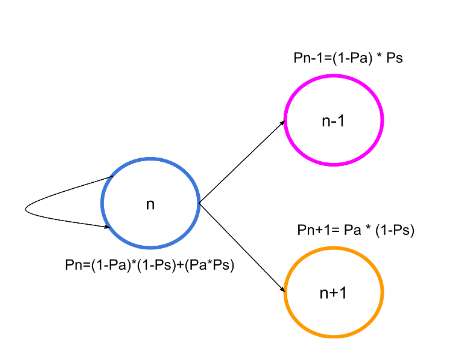

La matriz de transicion de estados queda de la forma:

$$P = \begin{bmatrix}
1-P_{a} & P_{a} & 0 & 0 & ...\\
P_{n-1} & P_{n} & P_{n+1} & 0 & ...\\
0 & P_{n-1} & P_{n} & P_{n+1} & ...\\
0 & 0 & P_{n-1} & P_{n} & ...\\
... & ... & ... & ... & ... \\
\end{bmatrix}$$

con n: cantidad máxima de solicitudes que puede procesar el sistema

__b.__ Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.

In [28]:
import random as rn
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def simulacion(tiempo,step,rand_op):
    Pa = 1/40
    Ps = 1/30
    estado = 0
    solicitudes_totales = 0
    tiempos = []
    cant_solicitudes_x_fraccion = []
    tiempo_sin_solicitudes = 0
    for x in range(0, tiempo * 1000, step):
        u = rand_op()
        if (estado == 0):
            if (u > 1-Pa): #ingresa solicitud
                solicitudes_totales += 1
                estado += 1
            else:
                tiempo_sin_solicitudes += step
        else:
            if (u <= (Ps*(1-Pa))):#egresa solicitud
                estado -= 1
            elif (u > 1 - (Pa*(1-Ps))): #ingresa solicitud
                solicitudes_totales += 1
                estado += 1
        tiempos.append(x)
        cant_solicitudes_x_fraccion.append(estado)   
        
    return tiempos, cant_solicitudes_x_fraccion, solicitudes_totales, tiempo_sin_solicitudes

In [30]:
tiempos, cant_solicitudes_x_fraccion, total_solicitudes_procesadas, tiempo_sin_solicitudes = simulacion(1000, 10,rn.random)

__c.__ Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.


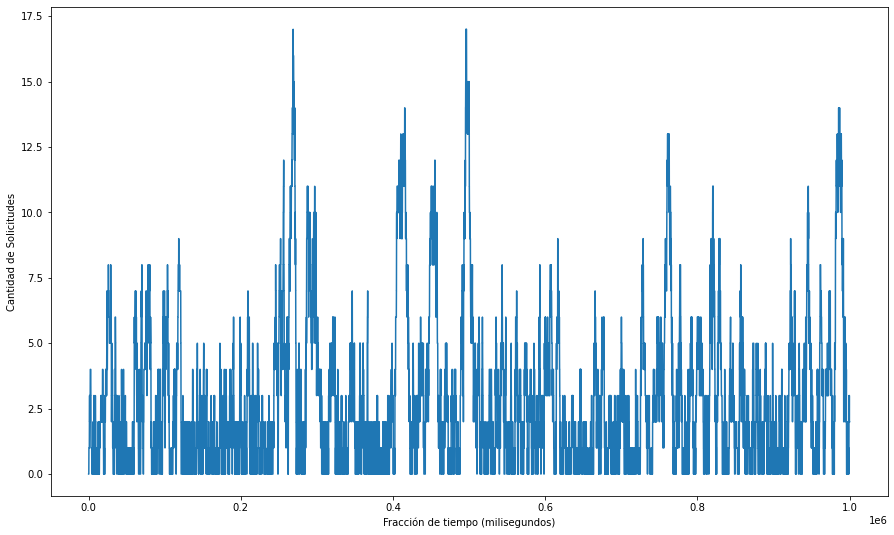

In [31]:
print("c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.")
plt.figure(figsize=(15,9))
plt.plot(tiempos,cant_solicitudes_x_fraccion)
plt.xlabel('Fracción de tiempo (milisegundos)')
plt.ylabel('Cantidad de Solicitudes')
plt.savefig('solicitudes_x_tiempo.jpg', dpi=300, bbox_inches='tight')

El sistema no llega a saturarse (el máximo de solicitudes se encuentra alrededor de 19 cuando el máximo soportado es 30), esto podría deberse a que la probabilidad de egreso del sistema es mayor a la probabilidad de arribo

__d.__ Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado


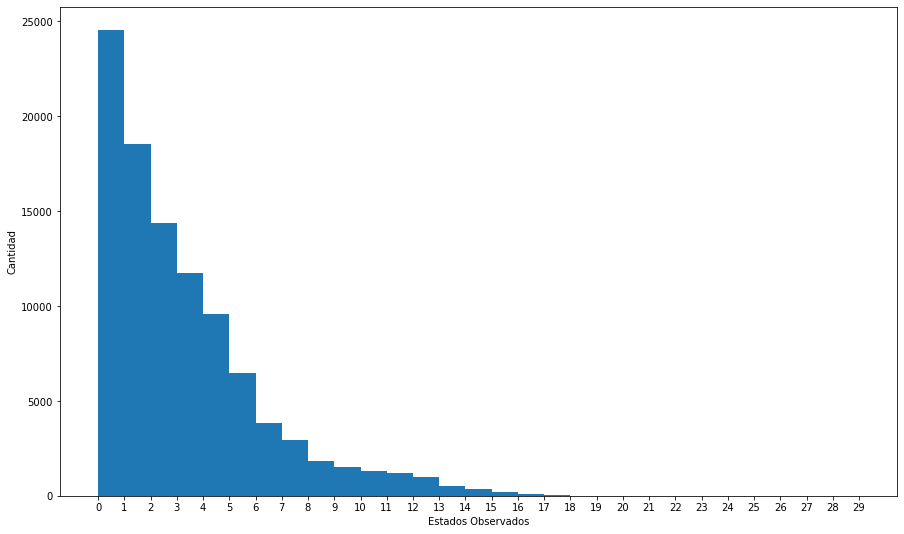

In [32]:
print("d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado")
plt.figure(figsize=(15,9))
plt.hist(cant_solicitudes_x_fraccion,bins=range(0, 30, 1))
plt.xlabel('Estados Observados')
plt.ylabel('Cantidad')
plt.xticks(np.arange(0, 30, step=1))
plt.savefig('histograma_estados.jpg', dpi=300, bbox_inches='tight')

__e.__ Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

Consideramos que el servidor no procesa solicitudes en aquellos momentos en los cuales el estado = 0.

Pasamos el tiempo en el que el sistema no procesó solicitudes a segundos y calculamos el porcentaje que representa respecto del total de 1000 segundos

In [33]:
print(str(((tiempo_sin_solicitudes / 1000) * 100) / 1000) + "%")

23.941%


__Probamos la simulacion con el generador xorshift__

In [34]:
rand_xorshift = xorshift(int(time.time()))

In [35]:
tiempos, cant_solicitudes_x_fraccion, total_solicitudes_procesadas, tiempo_sin_solicitudes = simulacion(1000, 10,rand_xorshift.uniform_rand)

c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.


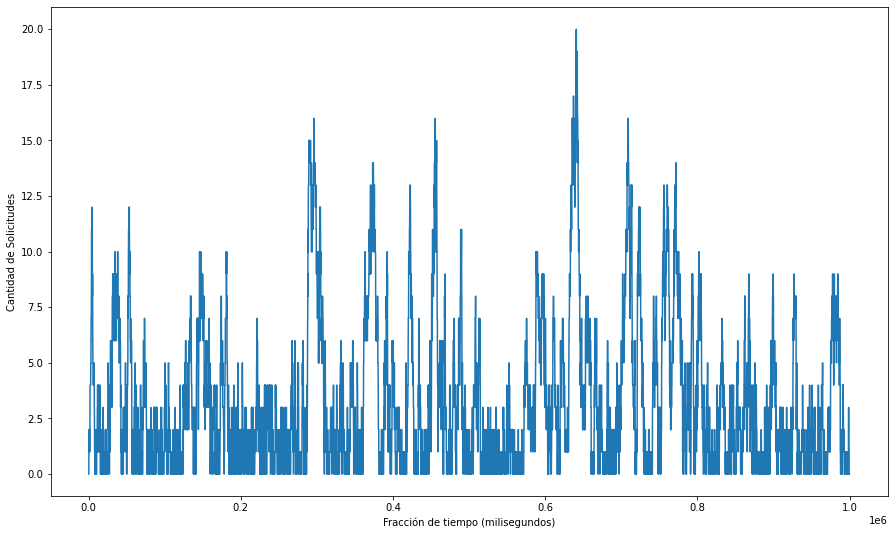

In [36]:
print("c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.")
plt.figure(figsize=(15,9))
plt.plot(tiempos,cant_solicitudes_x_fraccion)
plt.xlabel('Fracción de tiempo (milisegundos)')
plt.ylabel('Cantidad de Solicitudes')
plt.savefig('solicitudes_x_tiempo_xorshift.jpg', dpi=300, bbox_inches='tight')

d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado


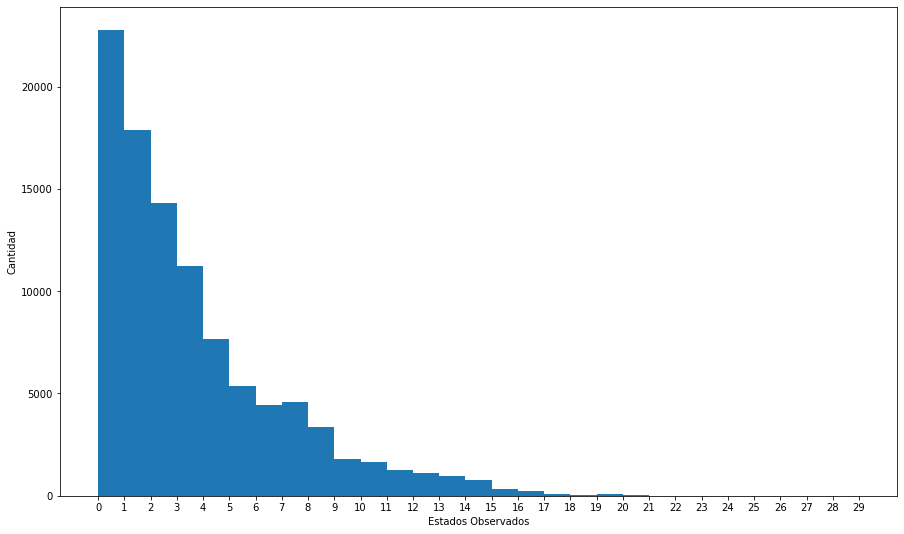

In [37]:
print("d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado")
plt.figure(figsize=(15,9))
plt.hist(cant_solicitudes_x_fraccion,bins=range(0, 30, 1))
plt.xlabel('Estados Observados')
plt.ylabel('Cantidad')
plt.xticks(np.arange(0, 30, step=1))
plt.savefig('histograma_estados_xorshift.jpg', dpi=300, bbox_inches='tight')

In [38]:
print(str(((tiempo_sin_solicitudes / 1000) * 100) / 1000) + "%")

22.194%


__Probamos la simulacion con el generador opcional__

In [39]:
rand_op=RandOp()

In [40]:
tiempos, cant_solicitudes_x_fraccion, total_solicitudes_procesadas, tiempo_sin_solicitudes = simulacion(1000, 10,rand_op.uniform_rand)

c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.


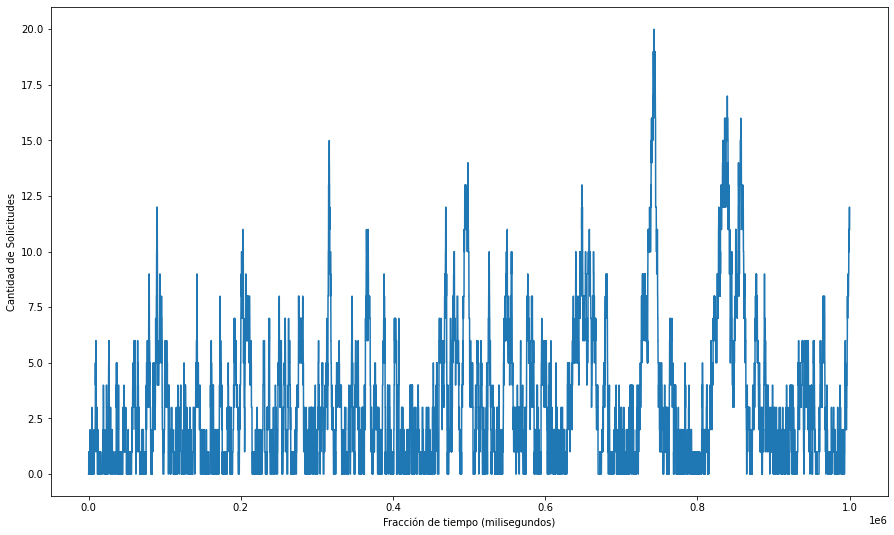

In [41]:
print("c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.")
plt.figure(figsize=(15,9))
plt.plot(tiempos,cant_solicitudes_x_fraccion)
plt.xlabel('Fracción de tiempo (milisegundos)')
plt.ylabel('Cantidad de Solicitudes')
plt.savefig('solicitudes_x_tiempo_opcional.jpg', dpi=300, bbox_inches='tight')

d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado


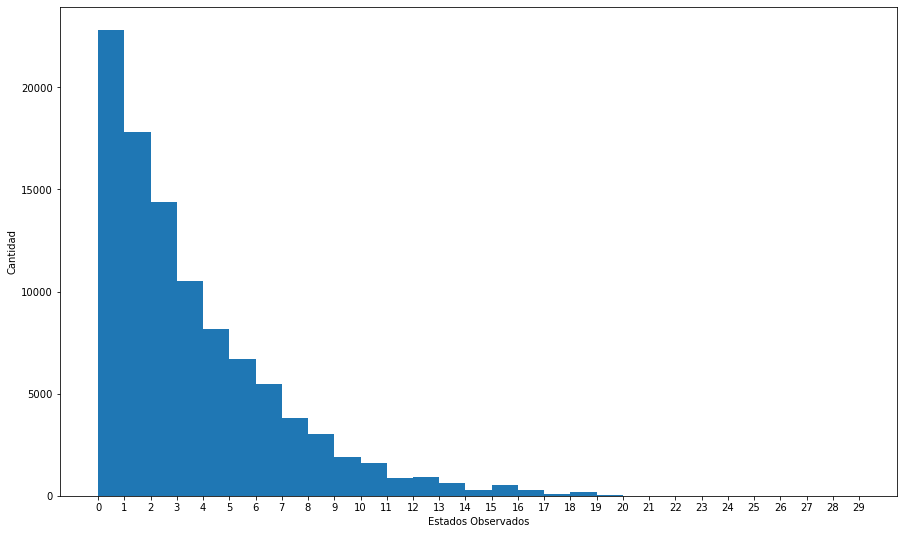

In [42]:
print("d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado")
plt.figure(figsize=(15,9))
plt.hist(cant_solicitudes_x_fraccion,bins=range(0, 30, 1))
plt.xlabel('Estados Observados')
plt.ylabel('Cantidad')
plt.xticks(np.arange(0, 30, step=1))
plt.savefig('histograma_estados_opcional.jpg', dpi=300, bbox_inches='tight')

In [43]:
print(str(((tiempo_sin_solicitudes / 1000) * 100) / 1000) + "%")

22.237%
